In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

import xgboost as xgb
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [2]:
df_all = pd.read_csv('C:/Temp/n=2_all_data - order2.csv')

In [3]:
# Columns are:
# defining_polynomial,
# degree_extension,
# class_number,
# signature (r_1,r_2),
# real_embeddings r_1,
# complex_embeddings r_2,
# rank_unit_group,
# number_roots_unity,
# conductor,
# discriminant,
# regulator,
# residue_at_s=1,
# zeta_coefficients,
# _2, _3, _4, _5, ..., _1000

# print(df_all.columns.tolist())

In [4]:
print(df_all.iloc[0:3, np.r_[0,1,2,7,8,9,10,11:13]])

  defining_polynomial  degree_extension  class_number  number_roots_unity  \
0         x^2 - x + 1                 2             1                   6   
1             x^2 + 1                 2             1                   4   
2         x^2 - x - 1                 2             1                   2   

   conductor  discriminant  regulator  residue_at_s=1  zeta_coefficients  
0          3            -3   1.000000        0.604600                  1  
1          4            -4   1.000000        0.785398                  1  
2          5             5   0.481212        0.430409                  1  


In [5]:
NEW_CLASS_NAME_ONE = 0
NEW_CLASS_NAME_TWO = 1
CLASSINDEX = 2 # Indicies starting by 0 = defining_polynomial ... 2 = class_number

In [6]:
df_all.class_number.value_counts()

2    182832
1    177168
Name: class_number, dtype: int64

In [7]:
df_all.class_number.replace(1, NEW_CLASS_NAME_ONE, inplace=True)
df_all.class_number.replace(2, NEW_CLASS_NAME_TWO, inplace=True)

In [8]:
df_all.class_number.value_counts()

1    182832
0    177168
Name: class_number, dtype: int64

In [9]:
df_train, df_test = train_test_split(df_all, test_size=0.3, stratify=df_all.iloc[:, CLASSINDEX])
# df_all.iloc[:, CLASSINDEX] => Select all rows by index (col) from df_all

## Achtung

X_test und y_test werden mehrfach verwendet, sind also keine echten Testdaten sondern Validierungsdaten

In [12]:
#col_train = np.r_[1,2,7,8,9,10,11:1001]
col_train = np.r_[11:1001]

# column to predict is 'class_number' (3rd column)
# column indexing is zero-based
y_train = df_train.iloc[:,CLASSINDEX]
y_test = df_test.iloc[:,CLASSINDEX]

# matrix of explanatory variables includes
X_train = df_train.iloc[:, col_train]
X_test = df_test.iloc[:, col_train]

### Logistic Regression

In [11]:
LR = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000).fit(X_train, y_train)
#LR.predict(df_test.iloc[:,2:9])

score = LR.score(X_test, y_test)
print(score)

A:\Apps\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.7746111111111111


### Support Vector Machine / Support Vector Regression

In [51]:
len(y_test_reduced)

20

In [52]:
df_reduced = df_all.sample(100)
# column 3 contains class values
df_train_reduced, df_test_reduced = train_test_split(df_reduced, test_size=0.2, stratify=df_reduced.iloc[:, CLASSINDEX])
col_train = np.r_[1,2,7,8,9,10,11:15]

# column to predict is 'class_number' (3rd column)
# column indexing is zero-based
y_train_reduced = df_train_reduced.iloc[:,CLASSINDEX]
y_test_reduced = df_test_reduced.iloc[:,CLASSINDEX]

# matrix of explanatory variables includes
X_train_reduced = df_train_reduced.iloc[:, col_train]
X_test_reduced = df_test_reduced.iloc[:, col_train]

svc_lin = svm.LinearSVC()
svc_nu = svm.NuSVC(gamma='auto')
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)
svr_poly.fit(X_train_reduced, y_train_reduced)

score = svr_poly.score(X_test_reduced, y_test_reduced)
print(score)

### Random Forest Classifier

In [13]:
RF = RandomForestClassifier(n_estimators=10, random_state=0)
RF.fit(X_train, y_train)

score = RF.score(X_test, y_test)
print(score)

0.9400092592592593


### Decision Tree Classifier

In [14]:
DT = DecisionTreeClassifier().fit(X_train, y_train)
print(DT.score(X_test, y_test))

0.8787314814814815


### Multilayer perceptron (neural network)

In [16]:
MLP = MLPClassifier(hidden_layer_sizes=(10,)).fit(X_train, y_train)
print(MLP.score(X_test, y_test))

A:\Apps\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning:

Training interrupted by user.



0.76175


### XGBoosts Classifier 

In [17]:
XGB = xgb.XGBClassifier(use_label_encoder=False, n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.5,
                        eval_metric="logloss")
XGB.fit(X_train, y_train)

score = XGB.score(X_test, y_test)
print(score)

0.8773981481481481


### AdaBoost Classifier

In [18]:
ADBoost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10)
ADBoost.fit(X_train, y_train)
print(ADBoost.score(X_test, y_test))

0.8786759259259259


### Visualization

In [22]:
df_plot = df_all.sample(4000)

dr1 = go.Scatter3d(
    x=df_plot[df_plot['class_number'] == 1]['discriminant'],
    y=df_plot[df_plot['class_number'] == 1]['regulator'],
    z=df_plot[df_plot['class_number'] == 1]['zeta_coefficients'],
    mode='markers',
    marker = dict(size=3,
                  color='rgb(255,0,0)',
                  line=dict(width=1)),
    name ='Discriminant-Regulator-_1'
)
dr2 = go.Scatter3d(
    x=df_plot[df_plot['class_number'] == 2]['discriminant'],
    y=df_plot[df_plot['class_number'] == 2]['regulator'],
    z=df_plot[df_plot['class_number'] == 2]['zeta_coefficients'],
    mode='markers',
    marker = dict(size=3,
                  color='rgb(0,255,0)',
                  line=dict(width=1)),
    name ='Discriminant-Regulator-_2'
)

data = [dr1, dr2]
layout = go.Layout(
    title='class_number',
    scene = dict(
        xaxis = dict(title='blue'),
        yaxis = dict(title='red'),
        zaxis = dict(title='green'),)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='class_number')

In [6]:
# useful links
# https://www.kaggle.com/robjan/binary-classification-with-visualization
# https://stackabuse.com/classification-in-python-with-scikit-learn-and-pandas


    defining_polynomial  class_number  number_roots_unity  _2  _3
400       x^2 - x - 634             0                   2   2   0
401       x^2 - x - 637             0                   2   0   0
402       x^2 - x - 642             0                   2   2   2
403           x^2 - 643             0                   2   1   2
404       x^2 - x - 643             0                   2   0   0
405       x^2 - x - 644             0                   2   2   1
406           x^2 - 647             0                   2   1   0
407       x^2 - x - 648             0                   2   2   2
408       x^2 - x - 652             0                   2   2   0
409       x^2 - x - 654             0                   2   2   2
410       x^2 - x - 655             0                   2   0   0


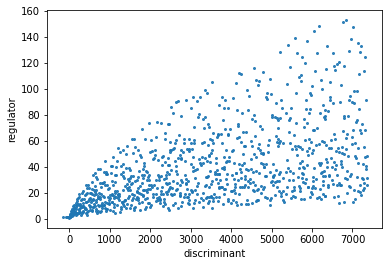

In [23]:
print(df_all.loc[400:410, ['defining_polynomial', 'class_number', 'number_roots_unity', '_2', '_3']])
df_plot = df_all.iloc[0:1000]
# df_plot = df_all
x = df_plot['discriminant'].to_numpy()
y = df_plot['regulator'].to_numpy()
colors = df_all['class_number']
color_map = {1:'red', 2:'blue'}

f = plt.figure()
# plt.scatter(x, y, s=4, alpha=0.9, c=colors.map(color_map))
plt.scatter(x, y, s=4, alpha=0.9)
# plt.title("class 1 (red) and class 2 (blue) for x^2 + bx + c")
plt.xlabel("discriminant")
plt.ylabel("regulator")
plt.show()